## Imports

In [46]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, train_test_split, ValidationCurveDisplay, validation_curve

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import tuning_search_top_configs
from training.metrics import mean_euclidean_error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# K-NN
In this notebook we test a **KNeighborsClassifier** and a **KNeighborsRegressor** w.r.t. the tasks at hand, i.e. the three MONK's problems and the CUP dataset respectively.

In [4]:
MODEL_NAME = 'K-NN'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS=5 # for cross-validation

## Path

In [5]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [6]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Grid search
Grid search is a simple hyper-parameter tuning techniques useful for finding the best configuration for a specific ML model. It involves:
- defining a grid of hparams values
- systematically test all possible combinations


In [7]:
# hparams grid for grid search
clf_hparams_spaces = {'n_neighbors': list(range(2,int(len(x_dev_m1)/2))),
                      'weights': ['uniform', 'distance'],
                      'p': [1,2]
                     }

In [8]:
# perform grid search with KFold

grid_search_m1 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m1.fit(x_dev_m1, y_dev_m1)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [10]:
best_configs_m1 = tuning_search_top_configs(grid_search_m1.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
Mean score 0.8223 - Std score: 0.0218

Model rank 2 - Config: {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
Mean score 0.8223 - Std score: 0.0218

Model rank 3 - Config: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Mean score 0.8147 - Std score: 0.0311

Model rank 4 - Config: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mean score 0.8147 - Std score: 0.0401

Model rank 5 - Config: {'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Mean score 0.8067 - Std score: 0.0382



In [13]:
# Create a SVC with the best hparams
#knn_m1 = KNeighborsClassifier(**grid_search_m1.best_params_)


# Train the model
knn_m1 = KNeighborsClassifier(n_neighbors=22, p=1, weights='distance')
knn_m1.fit(x_dev_m1, y_dev_m1)


KNeighborsClassifier(n_neighbors=22, p=1, weights='distance')

In [14]:
print('-- DEVELOPMENT --')
acc_dev_m1 = accuracy_score(y_dev_m1, knn_m1.predict(x_dev_m1))
mse_dev_m1 = mean_squared_error(y_dev_m1, knn_m1.predict(x_dev_m1))
print(f'Loss (MSE): {mse_dev_m1:.4f} - Accuracy: {acc_dev_m1:.4f}')

-- DEVELOPMENT --
Loss (MSE): 0.0000 - Accuracy: 1.0000


In [15]:
print('-- TEST --')
acc_test_m1 = accuracy_score(y_test_m1, knn_m1.predict(x_test_m1))
mse_test_m1 = mean_squared_error(y_test_m1, knn_m1.predict(x_test_m1))
print(f'Loss (MSE): {mse_test_m1:.4f} - Accuracy: {acc_test_m1:.4f}')

-- TEST --
Loss (MSE): 0.1713 - Accuracy: 0.8287


## Store results

In [16]:
report_m1 = {
    'dev': {'mse': mse_dev_m1, 'accuracy': acc_dev_m1},
    'test': {'mse': mse_test_m1, 'accuracy': acc_test_m1}
}

store_monk_result(results_dir + '/MONK1/', knn_m1.get_params(), report_m1)

# MONK-2

In [17]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

In [18]:
# perform grid search with KFold
grid_search_m2 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m2.fit(x_dev_m2, y_dev_m2)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [20]:
best_configs_m2 = tuning_search_top_configs(grid_search_m2.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 56, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 2 - Config: {'n_neighbors': 57, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 3 - Config: {'n_neighbors': 59, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 4 - Config: {'n_neighbors': 58, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 5 - Config: {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
Mean score 0.6390 - Std score: 0.0389



In [23]:
# Create a SVC with the best hparams
#knn_m2 = KNeighborsClassifier(**grid_search_m2.best_params_)

# Train the model
knn_m2 = KNeighborsClassifier(n_neighbors=56, p=1, weights='distance')
knn_m2.fit(x_dev_m2, y_dev_m2)

KNeighborsClassifier(n_neighbors=56, p=1, weights='distance')

In [24]:
print('-- DEVELOPMENT --')
acc_dev_m2 = accuracy_score(y_dev_m2, knn_m2.predict(x_dev_m2))
mse_dev_m2 = mean_squared_error(y_dev_m2, knn_m2.predict(x_dev_m2))
print(f'MSE: {mse_dev_m2:.4f} - Accuracy: {acc_dev_m2:.4f}')

-- DEVELOPMENT --
MSE: 0.0000 - Accuracy: 1.0000


In [25]:
print('-- TEST --')
acc_test_m2 = accuracy_score(y_test_m2, knn_m2.predict(x_test_m2))
mse_test_m2 = mean_squared_error(y_test_m2, knn_m2.predict(x_test_m2))
print(f'MSE: {mse_test_m2:.4f} - Accuracy: {acc_test_m2:.4f}')

-- TEST --
MSE: 0.1968 - Accuracy: 0.8032


In [26]:
report_m2 = {
    'dev': {'mse': mse_dev_m2, 'accuracy': acc_dev_m2},
    'test': {'mse': mse_test_m2, 'accuracy': acc_test_m2}
}

store_monk_result(results_dir + '/MONK2/', knn_m2.get_params(), report_m2)

# MONK-3

In [27]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

In [28]:
# perform grid search with KFold
grid_search_m3 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m3.fit(x_dev_m3, y_dev_m3)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [29]:
best_configs_m3 = tuning_search_top_configs(grid_search_m3.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 43, 'p': 1, 'weights': 'distance'}
Mean score 0.9273 - Std score: 0.0584

Model rank 2 - Config: {'n_neighbors': 45, 'p': 1, 'weights': 'distance'}
Mean score 0.9190 - Std score: 0.0498

Model rank 3 - Config: {'n_neighbors': 44, 'p': 1, 'weights': 'distance'}
Mean score 0.9107 - Std score: 0.0459

Model rank 4 - Config: {'n_neighbors': 43, 'p': 2, 'weights': 'distance'}
Mean score 0.9107 - Std score: 0.0459

Model rank 5 - Config: {'n_neighbors': 47, 'p': 1, 'weights': 'distance'}
Mean score 0.9030 - Std score: 0.0777



In [30]:
# Create a SVC with the best hparams
#knn_m3 = KNeighborsClassifier(**grid_search_m3.best_params_)

# Train the model
knn_m3 = KNeighborsClassifier(n_neighbors=43, p=1, weights='distance')
knn_m3.fit(x_dev_m3, y_dev_m3)

KNeighborsClassifier(n_neighbors=43, p=1, weights='distance')

In [31]:
print('-- DEVELOPMENT --')
acc_dev_m3 = accuracy_score(y_dev_m3, knn_m3.predict(x_dev_m3))
mse_dev_m3 = mean_squared_error(y_dev_m3, knn_m3.predict(x_dev_m3))
print(f'MSE: {mse_dev_m3:.4f} - Accuracy: {acc_dev_m3:.4f}')

-- DEVELOPMENT --
MSE: 0.0000 - Accuracy: 1.0000


In [32]:
print('-- TEST --')
acc_test_m3 = accuracy_score(y_test_m3, knn_m3.predict(x_test_m3))
mse_test_m3 = mean_squared_error(y_test_m3, knn_m3.predict(x_test_m3))
print(f'MSE: {mse_test_m3:.4f} - Accuracy: {acc_test_m3:.4f}')

-- TEST --
MSE: 0.0532 - Accuracy: 0.9468


In [33]:
report_m3 = {
    'dev': {'mse': mse_dev_m3, 'accuracy': acc_dev_m3},
    'test': {'mse': mse_test_m3, 'accuracy': acc_test_m3}
}

store_monk_result(results_dir + '/MONK3/', knn_m3.get_params(), report_m3)

# CUP

In [34]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

## Dev - Internal Test Split 
The development dataset is split between training and internal test ($90-10$).

In [35]:
# Split the internal test set
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, y_dev_cup, test_size=INTERNAL_TEST_SPLIT, random_state=128
)

# Hyperparameters tuning
Here, we define the grid search spaces for the KNN for the CUP dataset.

In [36]:
# hparams grid for grid search
grid_search_spaces_cup = {'n_neighbors': list(range(2,int(len(x_train_cup)/2))),
                          'weights': ['uniform', 'distance'],
                          'p': [1,2]
                         }

## Grid search

In [37]:
# perform grid search with KFold
grid_search_cup = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=grid_search_spaces_cup,
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring=make_scorer(mean_euclidean_error, greater_is_better = False),
    verbose=1
)

grid_search_cup.fit(x_train_cup, y_train_cup)

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_euclidean_error, greater_is_better=False),
             verbose=1)

In [38]:
best_configs_cup = tuning_search_top_configs(grid_search_cup.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Mean score -2.6174 - Std score: 0.1620

Model rank 2 - Config: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean score -2.6279 - Std score: 0.1865

Model rank 3 - Config: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Mean score -2.6446 - Std score: 0.1765

Model rank 4 - Config: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Mean score -2.6690 - Std score: 0.1277

Model rank 5 - Config: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mean score -2.6794 - Std score: 0.1826



## Random Search

In [39]:
best_params = grid_search_cup.best_params_
print(best_params)

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [47]:
random_search_spaces_cup = {'n_neighbors': randint(max(2, best_params['n_neighbors'] * 0.5), best_params['n_neighbors'] * 2),
                          'weights': [best_params['weights']],
                          'p': [1,2]
                         }

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.7s finished


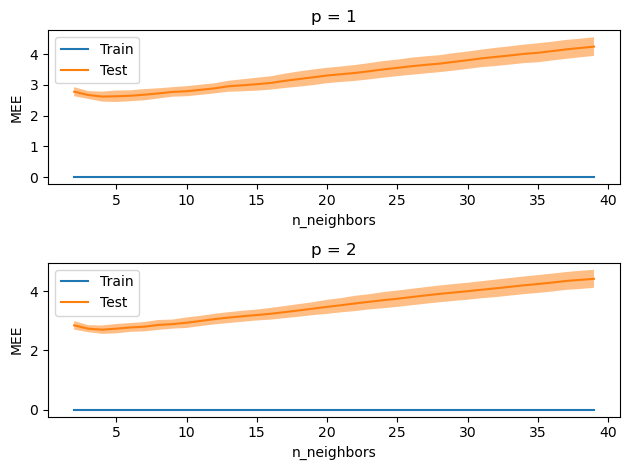

min_train_scores = [-0.0, -0.0]
min_test_scores = [-2.3619, -2.5012]


In [63]:
# Validation curves
param_name = "n_neighbors"
param_range = np.arange(2, best_params['n_neighbors'] * 10)
figure, axis = plt.subplots(2, 1)
min_train_scores=[]
min_test_scores=[]

for (p, i) in zip([1,2], [0,1]):
    train_scores, test_scores = validation_curve(KNeighborsRegressor(weights = best_params['weights'], p = p), 
                                          x_train_cup, 
                                          y_train_cup, 
                                          param_name=param_name, 
                                          param_range=param_range,
                                          cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                                          scoring= make_scorer(mean_euclidean_error, greater_is_better = False),
                                          verbose=1)
    
    min_train_scores.append(round(np.max(train_scores),4)) #score is negative
    min_test_scores.append(round(np.max(test_scores),4)) 
                                          
    display = ValidationCurveDisplay(param_name=param_name, 
                                     param_range=param_range,
                                     train_scores=train_scores, 
                                     test_scores=test_scores,
                                     score_name="MEE")
    display.plot(ax=axis[i], negate_score = True)
    axis[i].set_title('p = %d' %p)

figure.tight_layout()
plt.show()
print(f"min_train_scores = {min_train_scores}")
print(f"min_test_scores = {min_test_scores}")

In [48]:
random_search_cup = RandomizedSearchCV(
    KNeighborsRegressor(), 
    random_search_spaces_cup, 
    n_iter=100, # number of configs sampled (do >100)
    cv=KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE),
    scoring=make_scorer(mean_euclidean_error, greater_is_better = False),
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_cup.fit(x_train_cup, y_train_cup)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
                   estimator=KNeighborsRegressor(), n_iter=100,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ff6efc6cbd0>,
                                        'p': [1, 2], 'weights': ['distance']},
                   random_state=128,
                   scoring=make_scorer(mean_euclidean_error, greater_is_better=False),
                   verbose=1)

In [49]:
best_score_grid = grid_search_cup.best_score_
best_score_random = random_search_cup.best_score_

# Check if best result is from GridSearc or RandomSearch
if best_score_random > best_score_grid:
    print("Best configuration from RandomizedSearch:\n")
    best_params = random_search_cup.best_params_
    print(best_params)
else:
    print("GridSearchCV resulted in the best configuration.")

GridSearchCV resulted in the best configuration.


## Training - testing

In [50]:
# Create a KNN with the best hparams
knn = KNeighborsRegressor(**best_params)

# Train the model
knn.fit(x_train_cup, y_train_cup)

KNeighborsRegressor(n_neighbors=4, p=1, weights='distance')

In [51]:
print('-- TRAINING --')
mee_train_cup = mean_euclidean_error(y_train_cup, knn.predict(x_train_cup))
mse_train_cup = mean_squared_error(y_train_cup, knn.predict(x_train_cup))
print(f'Loss (MSE): {mse_train_cup:.4f} - MEE: {mee_train_cup:.4f}')

-- TRAINING --
Loss (MSE): 0.0000 - MEE: 0.0000


In [52]:
print('-- INTERNAL TEST --')
mee_internal_test_cup = mean_euclidean_error(y_internal_test_cup, knn.predict(x_internal_test_cup))
mse_internal_test_cup = mean_squared_error(y_internal_test_cup, knn.predict(x_internal_test_cup))
print(f'Loss (MSE): {mse_internal_test_cup:.4f} - MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
Loss (MSE): 3.5642 - MEE: 2.6406


In [53]:
# Blind test set predictions
blind_test_preds_cup = knn.predict(x_test_cup)

## Store Result

In [54]:
best_index = grid_search_cup.best_index_
mee_mean_score = -grid_search_cup.cv_results_['mean_test_score'][best_index]
mee_std_dev = std_validation_error = grid_search_cup.cv_results_['std_test_score'][best_index]

report_cup = {
    'train': {'mse': mse_train_cup, 'mee': mee_train_cup},
    'validation': {'mean_mee': mee_mean_score, 'std_dev_mee': mee_std_dev},
    'internal_test': {'mse': mse_internal_test_cup, 'mee': mee_internal_test_cup},
}

store_cup_result(results_dir + '/CUP/', best_params, report_cup, blind_test_preds_cup)